# House pricing on the basis of square footage and realtor assesment

## Problem formulation

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

### Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [58]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()

The sqft living metrage is centered and standardized for the purpose of the further analysis.

In [59]:

mean_sqft_living = (df['sqft_living']).mean()
sd_sqft_living = (df['sqft_living']).std()
sqft_living_centered = ((df['sqft_living']).copy())
sqft_living_standardized = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living


In [60]:
grade_moved = ((df['grade']).copy())
for i in range(len(grade_moved)):
    grade_moved[i] = int(grade_moved[i]-6)
print(f"MIN: {grade_moved.min()} MAX: {grade_moved.max()}")

MIN: 0 MAX: 5


## Model 1 - one parameter

Model 1 is basing the predictions of the price of house on the basis of the area of the living space of the house.

### Prior

The parameters for the prior have been selected on the basis of a reseach on the Internet for the mean price and price for the square feet of the house in United States for year 2014 in similar location. 

In [6]:
with open('CommandFiles/one_param_ppc.stan', 'r') as f:
    print(f.read())

data {
    int N;
    vector [N] sqft;
}

generated quantities {
    real <lower=0> alpha =  normal_rng(360000, 150000); // taken from the mean value of the prices
    real <lower=0> beta = normal_rng(210, 100); // 
    real sigma = exponential_rng(0.01);
    vector [N] price;
    for (i in 1:N) {
        price[i] = normal_rng(alpha + sqft[i]*beta, sigma);
    }

}


The alpha parameter is based on the average house price in the USA in similar locations in 2014. The 360k is the mean value and 150k distribution is quite wide to take into account the differences in the region. The beta parameter is based on the average price per square feet, here also the distribution is quite wide, as it can depend on the state of the house, its location and multitude of different things.

In [61]:
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}

In [62]:
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Prior predictive check. The peak in all the parameters in 0 is due to constraint given in the stan file, such as alpha and beta cannot be lower than 0.

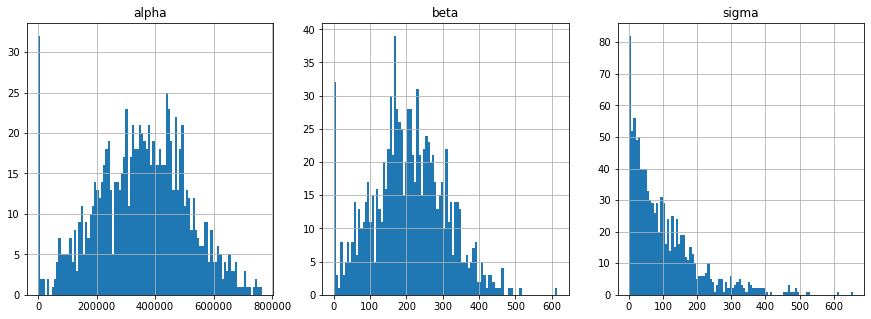

,mean,sd,hdi_3%,hdi_97%
alpha,352321.48,158063.89,0.0,592987.00
beta,206.29,101.33,0.0,364.79
sigma,100.88,99.54,0.0,295.96


In [63]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=100);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim, bins=100);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim, bins=100);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Prior predictive check for measurements. We can see however that for some prices are negative, but most of the generated measuremets are in the expected range.

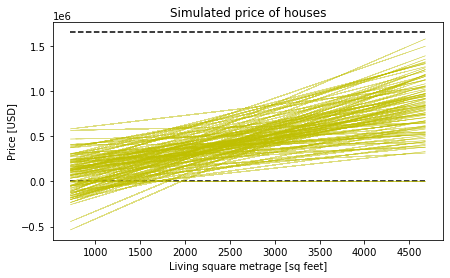

In [64]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [0,(df['price']).max()],
    xmin=df['sqft_living'].min(),
    xmax=df['sqft_living'].max(),
    linestyle='--',color='black'
    )
for i in range(100):
    axes.plot(
        df['sqft_living'],
        alpha_sim[i]+beta_sim[i]*sqft_living_centered,
        color = 'y', alpha=0.5, linewidth=0.5
        )
plt.title("Simulated price of houses");
plt.xlabel("Living square metrage [sq feet]");
plt.ylabel("Price [USD]");

Prior data repersents the data and is kept in the price min/max range quite well.

### Posterior

In [65]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


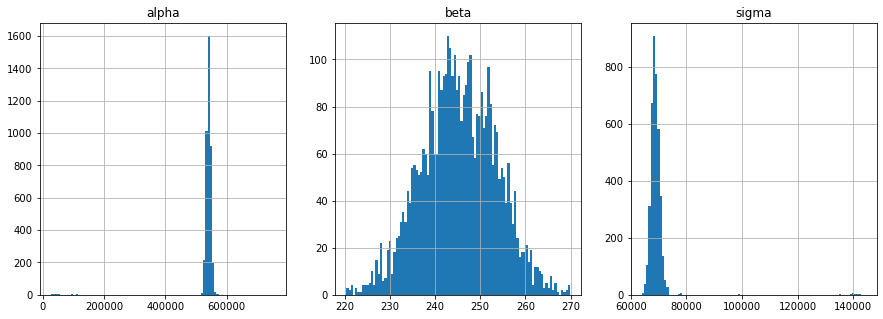

,mean,sd,hdi_3%,hdi_97%
alpha,538124.90,38838.73,527057.00,553453.00
beta,245.28,8.18,231.04,261.51
sigma,69256.90,5752.16,66137.80,71767.00


In [66]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=100);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim, bins=100);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim, bins=100);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Here we can see that the majority of tha parameter alpha is concentrated around 500k. The beta is slightly diffused with most of the parameter concentrated around 245.

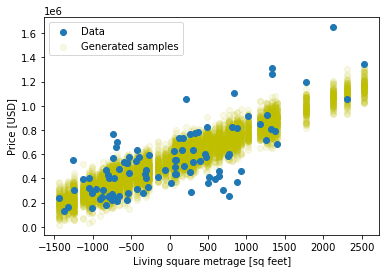

In [67]:
prices_sim=one_param_simulated.stan_variable('price_sim')

plt.scatter(sqft_living_centered, df["price"], zorder=2)
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)
plt.legend(['Data', 'Generated samples'])
plt.xlabel("Living square metrage [sq feet]");
plt.ylabel("Price [USD]");

We can see that the generated samples correspond to the majority of the data. There are however some outliers. The fit corespodns well to linear regresion.

## Model 2 - discrete grade

### Prior

In this prior we added another parameter to improve the predictions - grade of the house, given by the realtor.

In [3]:
with open('CommandFiles/two_param_discrete_ppc.stan', 'r') as f:
    print(f.read())

data {
    int N;
    vector [N] sqft;
    int grade[N];
}

generated quantities {
    real alpha =  normal_rng(360000, 150000); // taken from the mean value of the prices
    real beta_sqft = normal_rng(210, 100);
    vector [6] beta_grade;
    for (i in 1:6) {
        beta_grade[i] = normal_rng(100000, 200000);
    }
    real sigma = exponential_rng(0.01);
    vector [N] price;
    for (i in 1:N) {
        price[i] = normal_rng(alpha + sqft[i]*beta_sqft + beta_grade[grade[i]+1], sigma);
    }
}


Here the alpha parameter corresponds to the alpha parameter from the first model, and the beta_sqft corresponds to beta. There's new parameter - beta_grade, which is a vector of parameters, different for each discrete grade it is given. The range of normal distribution of the new parameter beta_grade is very wide and contains negative and positive values to reflect how the grade can affect the price of the house.

In [68]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max(),100)
grade_in = grade_moved.sample(100).sort_values()

data = {'N': len(sqft_linspace),
        'sqft': sqft_living_centered,
        'grade': grade_in}
two_params_discrete_ppc = CmdStanModel(stan_file='CommandFiles/two_param_discrete_ppc.stan')
two_params_discrete_ppc_simulated = two_params_discrete_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


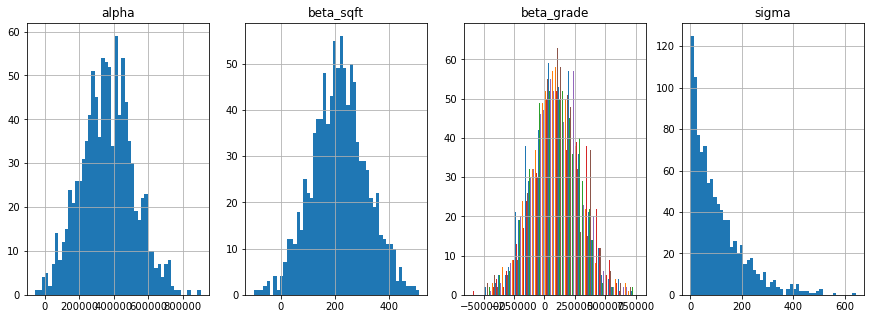

,mean,sd,hdi_3%,hdi_97%
alpha,360879.36,151958.76,59598.70,624398.00
beta_sqft,216.91,101.43,39.75,419.47
beta_grade[0],96549.79,199589.60,-254705.00,476141.00
beta_grade[1],98918.53,199478.78,-334956.00,417825.00
beta_grade[2],85498.75,199133.44,-286491.00,440735.00
beta_grade[3],111578.13,199931.50,-263238.00,480191.00
beta_grade[4],91907.74,196673.96,-274963.00,454903.00
beta_grade[5],95484.07,199936.23,-288437.00,455202.00
sigma,105.33,100.78,0.01,292.39


In [69]:
alpha_sim = two_params_discrete_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_discrete_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_discrete_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_discrete_ppc_simulated.stan_variable('sigma')
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=50)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim, bins=50)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim, bins=50)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim, bins=50)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_discrete_ppc_simulated, var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

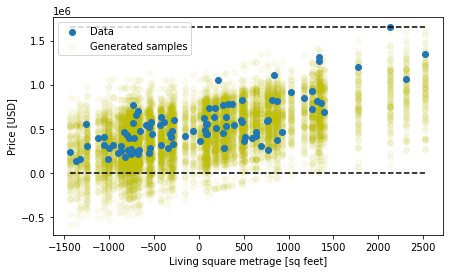

In [70]:
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')


fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.scatter(sqft_living_centered, df['price'], zorder=2)
for i in range(100):
    plt.scatter(
        sqft_living_centered,
        price_sim[i],
        color = 'y', alpha=0.07, linewidth=0.5
        )
axes.hlines(
    [0,(df['price']).max()],
    xmin=sqft_living_centered.min(),
    xmax=sqft_living_centered.max(),
    linestyle='--', color='black'
    )

plt.legend(['Data', 'Generated samples'])
plt.xlabel("Living square metrage [sq feet]");
plt.ylabel("Price [USD]");

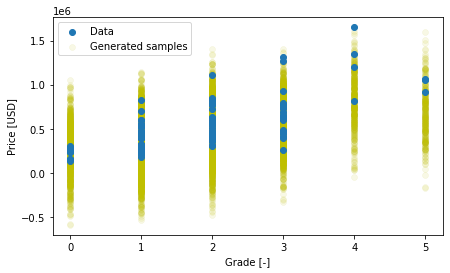

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.scatter(grade_moved, df['price'], zorder=2)
for i in range(100):
    plt.scatter(
        grade_moved,
        price_sim[i],
        color = 'y', alpha=0.1, linewidth=0.5
        )

plt.legend(['Data', 'Generated samples'])
plt.xlabel("Grade [-]");
plt.ylabel("Price [USD]");

Prior is quite wide in relationsip to data is good because it gives big room for the posterior to fit do data

### Posterior

In [72]:
data = {'N': len(sqft_living_standardized),
        'sqft': sqft_living_standardized,
        'grade': grade_moved,
        'price': df['price']}
two_params_discrete = CmdStanModel(stan_file='CommandFiles/two_param_discrete.stan')
two_params_simulated_discrete = two_params_discrete.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |███████▎  | 00:07 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:07 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:08 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:08 Iteration: 


INFO:cmdstanpy:CmdStan done processing.


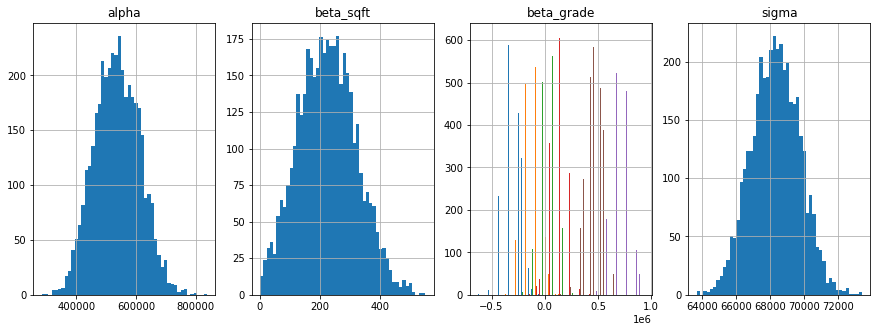

,mean,sd,hdi_3%,hdi_97%
alpha,536220.39,75706.64,391678.00,668170.00
beta_sqft,224.90,95.61,55.95,412.16
beta_grade[0],-309488.20,78029.71,-452946.00,-173097.00
beta_grade[1],-127758.90,76646.50,-262315.00,19076.80
beta_grade[2],31028.99,76664.28,-104502.00,176427.00
beta_grade[3],130882.45,76780.36,-1687.85,277879.00
beta_grade[4],700561.52,80974.57,550961.00,853295.00
beta_grade[5],460325.69,81659.43,309089.00,607284.00
sigma,68324.83,1405.98,65631.80,70790.90


In [73]:
alpha_sim = two_params_simulated_discrete.stan_variable('alpha')
beta_grade_sim = two_params_simulated_discrete.stan_variable('beta_grade')
beta_sqft_sim = two_params_simulated_discrete.stan_variable('beta_sqft')
sigma_sim = two_params_simulated_discrete.stan_variable('sigma')
price_sim = two_params_simulated_discrete.stan_variable('prices')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim, bins=50)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim, bins=50)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim, bins=50)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim, bins=50)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_simulated_discrete, var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

1. Aplha parameter here is a aproximation of average house price in King County, its a bit above average
2. Beta for sqft is aroung 30 USD lower than in one param model
3. Beta grade paramaters are layed out very interestingly, they are getting larger with sample and for lower grades ar even smaller than zero whitch means thaht they substract from house value.

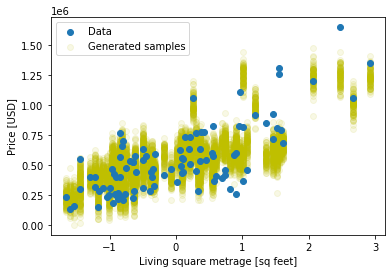

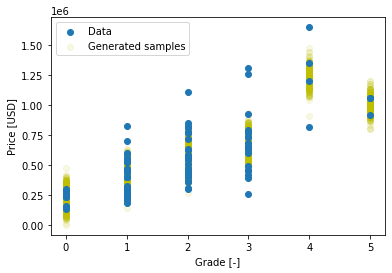

In [81]:
price_sim = two_params_simulated_discrete.stan_variable('prices')


plt.scatter(sqft_living_standardized, df['price'], zorder=2)
for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.legend(['Data', 'Generated samples'])
plt.xlabel("Living square metrage [sq feet]");
plt.ylabel("Price [USD]");
plt.show()

plt.scatter(grade_moved, df['price'], zorder=2)
for i in range(100):
    plt.scatter(grade_moved, price_sim[i], color="y", alpha=0.1)
    
plt.legend(['Data', 'Generated samples'])
plt.xlabel("Grade [-]");
plt.ylabel("Price [USD]");

1. Data fit for the sqare metrege looks quit accurate
2. Data fit for Grade has many outliers 

## Comparison of models

Prepare comparison:

In [239]:
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik");
idata2 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") ;
compare_dict = {"one_param_model": idata1, "two_param_discrete": idata2};

out_loo = az.compare(compare_dict, ic = "loo");
out_waic = az.compare(compare_dict, ic = "waic"); # loo stands for leave one out cross validation

c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from p

### Criterion 1: loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-1630.062447,59.963239,0.000000,0.87221,80.306965,0.000000,True,log
one_param_model,1,-1951.922338,478.229619,321.859891,0.12779,63.157213,68.649899,True,log


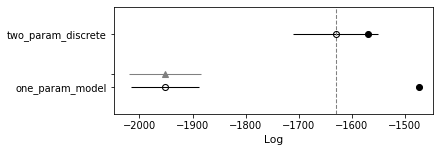

In [240]:
az.plot_compare(out_loo)
out_loo

1. The in-sample deviance of the models (black dots) has lesser value for one param model.
2. Rest of the measurements are far better for two parameter model, the std. deviation is smaller.
3. Weight (Probability of accurate prediction) of the two param model is 0.80 and for the one param model only 0.12
4. There is no overlap in standar deviations of both models

### Criterion 2: waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
two_param_discrete,0,-1630.091169,59.991961,0.000000,0.771616,80.352693,0.000000,True,log
one_param_model,1,-1687.700465,214.007745,57.609295,0.228384,44.967792,67.101629,True,log


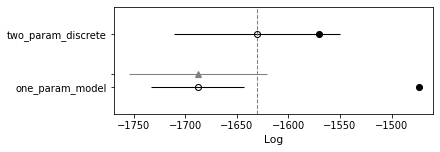

In [241]:
az.plot_compare(out_waic)
out_waic

1. Similarly to LOO the in-sample deviance is smaller for the one param model
2. Std. deviation of both models overlap greatly favoring the two param model
3. Weigt of the second model is 0.77 and 0.23 for first.